In [2]:
# Importing data from the r/politics
from psaw import PushshiftAPI
from datetime import datetime, timezone, date
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm, tqdm_pandas
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\JaQtae\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# WordCloud per candidate

In [3]:
# Downloading all the comments data (processed)
#url = 'https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_very_smol_fully_processed.csv'
local_storage = local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\Data\com_data_50plusComments_pruned_30plusComments.csv"
com_data = pd.read_csv(local_storage,index_col=0,parse_dates=[0])
com_data.index = com_data.index.rename('dates')
# The collected comments data set still contained some data from 2020-09-30. This is removed. 

# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)
com_data

,id,link_id,score,author,parent_id,body,parent_author,tokens,politician,children_comments,mentions_Trump,mentions_Biden
dates,,,,,,,,,,,,
2020-11-03 00:23:36,gaycvmz,t3_jmybs3,1,yyungpiss,t3_jmybs3,is there some sort of weird strategy to this o...,geoxol,"['sort', 'weird', 'strategy', 'something', 'la...",Trump,[],NaN,NaN
2020-11-02 23:26:26,gay6kwb,t3_jmybs3,1,J_Class_Ford,t1_gay5x5w,Division is his weapon,cyanydeez,"['division', 'weapon']",Trump,[],NaN,NaN
2020-11-02 23:20:27,gay5x5w,t3_jmybs3,1,cyanydeez,t1_gay5pjk,"dunno, everything trump does seems to generate...",J_Class_Ford,"['dunno', 'everything', 'trump', 'seems', 'gen...",Trump,['gay6kwb'],True,NaN
2020-11-02 23:18:33,gay5pjk,t3_jmybs3,1,J_Class_Ford,t1_gay5doq,Not sure it generates many more votes. I work ...,cyanydeez,"['not', 'sure', 'generates', 'many', 'votes', ...",Trump,['gay5x5w'],True,NaN
2020-11-02 23:15:36,gay5doq,t3_jmybs3,1,cyanydeez,t1_gay3si8,"yeah, but for every vote this generates, would...",J_Class_Ford,"['yeah', 'every', 'vote', 'generates', 'would'...",Trump,['gay5pjk'],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01 01:25:30,g78ozrz,t3_j2vwwt,1,5DollarHitJob,t3_j2vwwt,Can they just appeal this?,Plymouth03,"['can', 'appeal']",Trump,[],NaN,NaN
2020-10-01 01:24:25,g78ovcd,t3_j2vwwt,1,AmishTechno,t3_j2vwwt,"And, nothing will happen.",Plymouth03,"['and', 'nothing', 'happen']",Trump,[],NaN,NaN
2020-10-01 00:29:42,g78j6ey,t3_j2vwwt,1,ryhaltswhiskey,t1_g78iult,Ah I did not know that\r\n\r\nMan I hope Barr ...,memepolizia,"['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...",Trump,[],NaN,NaN


In [4]:
author_bodies = com_data.groupby(["politician"]).apply(lambda x: x["body"].unique())
author_bodies

politician
Biden    [I'm crazy. I'm not evil. I'm just like many o...
Trump    [is there some sort of weird strategy to this ...
dtype: object

In [5]:
trump_corpus = " ".join(author_bodies["Trump"])
biden_corpus = " ".join(author_bodies["Biden"])

In [6]:
# We solve this by defining the clean_tokens function below.
# Define stop words to also include punctuation
import nltk
stop = set(stopwords.words('english') + list(string.punctuation))

# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    # In the list comprehension below, we exclude URL's, stopwords and numbers as well as setting all characters to lowercase
    
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [re.sub(r'&\S+', '', str(i)) for i in clean_tokens]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

TTC = clean_tokens(trump_corpus)
TBC = clean_tokens(biden_corpus)

In [7]:
TTC_j = " ".join(TTC)
TBC_j = " ".join(TBC)
# Hader regex
TTC_j = TTC_j.replace(' gt', '')
TTC_j = TTC_j.replace(' amp', '')
TBC_j = TBC_j.replace(' gt', '')
TBC_j = TBC_j.replace(' amp', '')

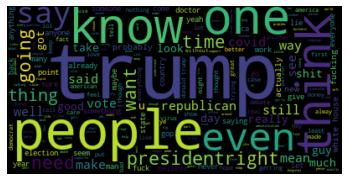

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud().generate(TTC_j)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

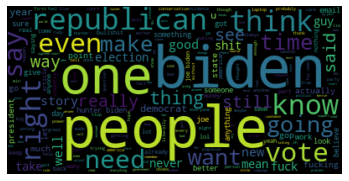

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud().generate(TBC_j)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Week 7 based
## Had to clean tokens, as they werent properly cleaned. This has been fixed at a later date, so one can replace cleaned_tokens with tokens and proceed.

In [10]:
com_data['cleaned_tokens'] = com_data['body'].progress_apply(lambda x: clean_tokens(x))

100%|████████████████████████████████████████████████████████████████████████| 104663/104663 [00:32<00:00, 3220.27it/s]


In [11]:
com_data['date'] = com_data.index
com_data['test'] = com_data['date'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d'))

In [62]:
documents_per_day = com_data.groupby("test").cleaned_tokens.sum()

In [63]:
for i in tqdm(range(len(documents_per_day))):
    
    #Remove gt's and amp's
    c1 = documents_per_day[i].count('gt')
    c2 = documents_per_day[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            documents_per_day[i].remove('gt')
            documents_per_day[i].remove('amp')
        except Exception:
            pass
        
    #Remove nothings
    c3 = documents_per_day[i].count('')
    for j in range(0,c3):
        try:
            documents_per_day[i].remove('')
        except Exception:
            pass


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:07<00:00,  5.12it/s]


# Log-scaled for better viewablity.
Here we see the "rule-of-thumb" of having 10,000 tokens per document in order to use dictionary based methods is applicable to the comments data set. (The submissions only contain the article url, and no selftext)

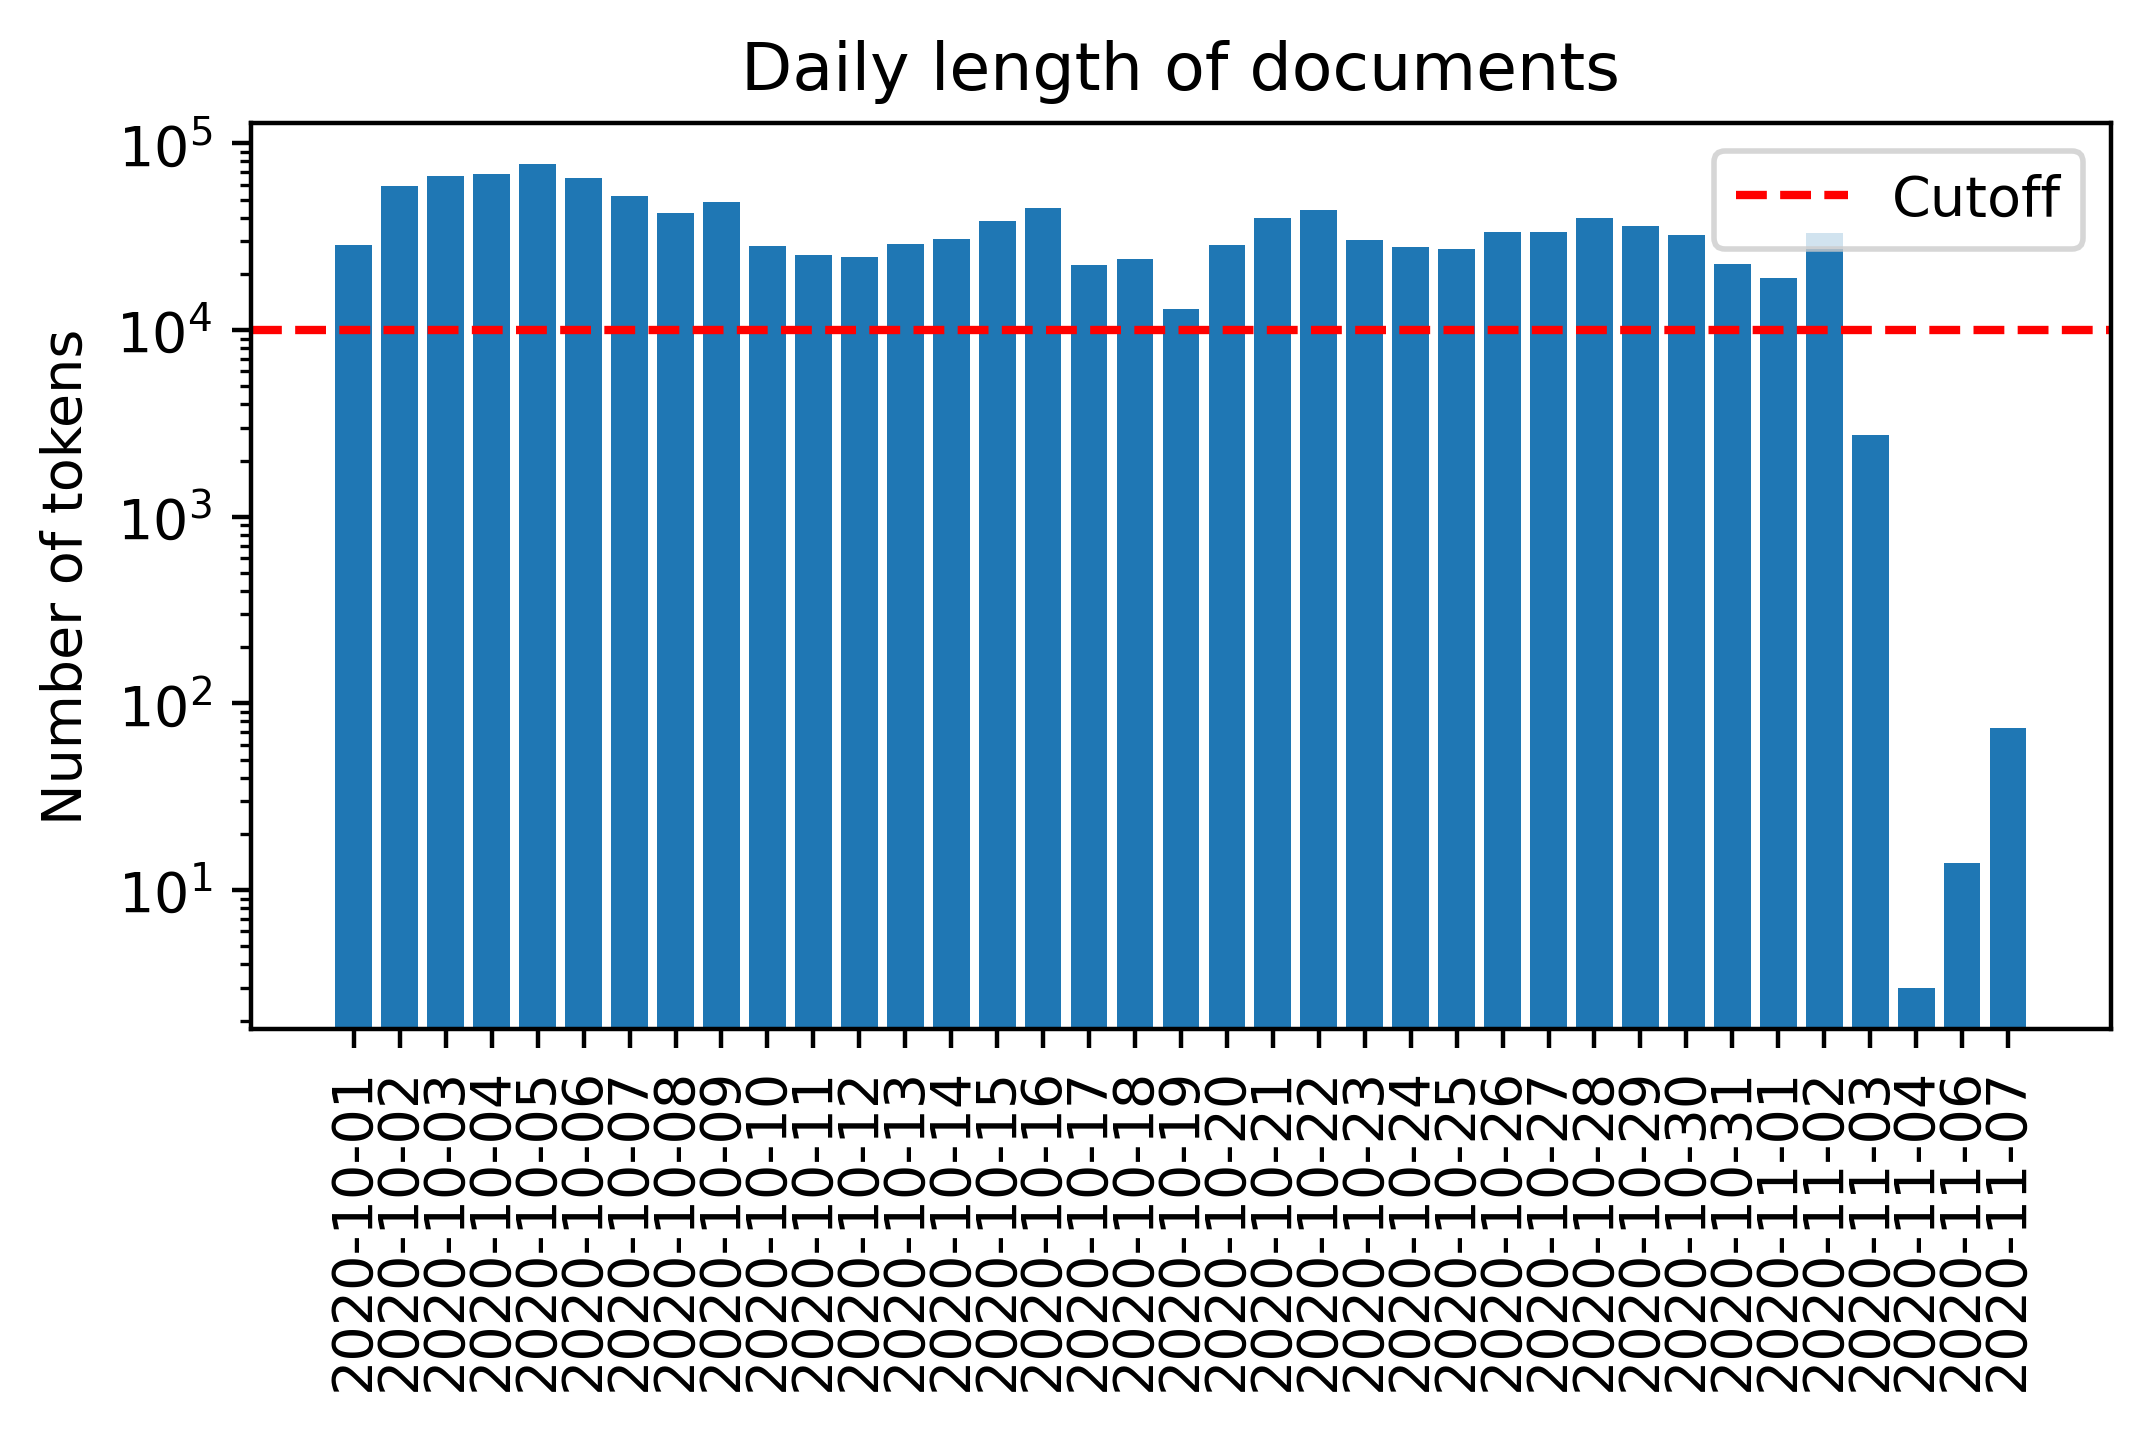

In [64]:
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
plt.xticks(rotation='vertical')
ax.bar(documents_per_day.index, [len(doc) for doc in documents_per_day])
ax.set_title("Daily length of documents")
ax.axhline(10000, color="red", linestyle="dashed", label="Cutoff")
ax.set_ylabel("Number of tokens")
ax.set_yscale('log')
ax.legend()

# Week 7 happiness scores

In [ ]:
labMT = pd.read_csv("Hedonometer.csv", index_col="Word")

In [ ]:
def hscore(tokens, p=False):
    #Iterative counter
    # If we want print p = True.
    score = 0
    freq_dict = dict(nltk.FreqDist(tokens))
    freq_norm = 0
    for word in tokens:
        # Count for word in dict
        try:
            score += labMT.loc[[word]]["Happiness Score"].values[0] * freq_dict[word]
            freq_norm += freq_dict[word]
        except:
            #Doesnt exist in labMT
            None
    hscore = score / (freq_norm+1e-06) #NaN for 0-division
    if p==True:
        return print("Happiness score: {}".format(hscore))
    else:
        return hscore


In [60]:
temp = com_data.groupby(['test', 'politician']).cleaned_tokens.sum()
for i in tqdm(range(len(temp))):
    c1 = temp[i].count('gt')
    c2 = temp[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            temp[i].remove('gt')
            temp[i].remove('amp')
        except Exception:
            pass

    c3 = temp[i].count('')
    for j in range(0,c3):
        try:
            temp[i].remove('')
        except Exception:
            pass
        

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 12.13it/s]
